# Churn prediction for an energy company 🔌💡
## Part 3 - Model Building
### Importing packages and models

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import optuna

# SAS models
from sasviya.ml.linear_model import LogisticRegression as SASLogisticRegression
from sasviya.ml.tree import DecisionTreeClassifier as SASDecisionTreeClassifier
from sasviya.ml.tree import ForestClassifier as SASForestClassifier
from sasviya.ml.tree import GradientBoostingClassifier as SASGradientBoostingClassifier

# scikit-learn classes and models
from sklearn.linear_model import LogisticRegression as SKLogisticRegression
from sklearn.tree import DecisionTreeClassifier as SKDecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier as SKRandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier as SKGradientBoostingClassifier
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, StandardScaler
from sklearn.metrics import roc_auc_score

from model_building_utils import *

target = 'churn'
repo_path = '/workspaces/myfolder/energy-churn-prediction'

### Model Building for non-transformed dataset

In [2]:
merged_df = pd.read_csv(f"{repo_path}/data/merged_data_no_tfm.csv")
merged_df.head(5)

,id,channel_sales,cons_gas_12m,cons_last_month,forecast_cons_12m,forecast_discount_energy,forecast_meter_rent_12m,has_gas,imp_cons,margin_net_pow_ele,...,price_off_peak_var_std,price_peak_var_std,price_off_peak_fix_std,price_peak_fix_std,price_off_peak_var_max_diff,price_peak_var_max_diff,price_peak_fix_max_diff,product_modified,contract_age_at_last_modif,days_to_end
0,24011ae4ebbe3035111d65fa7c15bc57,Channel 1,54946,0,0.00,0.0,1.78,Yes,0.00,25.44,...,0.007829,0.005126,1.050136,7.039226,0.028554,0.000568,0.097752,Yes,869,167
1,d29c2c54acc38ff3c0614d0a653813dd,Channel Missing,0,0,189.95,0.0,16.27,No,0.00,16.38,...,0.002212,0.024677,0.080404,0.000000,0.001567,0.085483,0.000000,No,0,243
2,764c75f661154dac3a6c254cd082ea7d,Channel 1,0,0,47.96,0.0,38.72,No,0.00,28.60,...,0.002396,0.000506,0.087532,0.000000,0.000000,0.001281,0.000000,No,0,107
3,bba03439a292a1e166f80264c16191cb,Channel 2,0,0,240.04,0.0,19.83,No,0.00,30.22,...,0.002317,0.000000,0.080403,0.000000,0.000000,0.000000,0.000000,No,0,90
4,149d57cf92fc41cf94415803a877cb4b,Channel Missing,0,526,445.75,0.0,131.73,No,52.32,44.91,...,0.003847,0.001885,0.073681,0.044209,0.001969,0.001867,0.097749,No,0,67


In [3]:
X_train, X_test, y_train, y_test, cat_cols, cat_cols_with_two_values, cat_cols_with_more_values, numeric_cols = split_data_and_generate_column_lists(merged_df, target)

- Number of rows with churn='No': 13131 (90.38 %)
- Number of rows with churn='Yes': 1398 (9.62 %)


In [4]:
sas_lr = SASLogisticRegression()
sklearn_lr = SKLogisticRegression(solver='liblinear')

preprocessor = ColumnTransformer(
    transformers=[
        ('binary', OrdinalEncoder(categories=[['No', 'Yes']]*len(cat_cols_with_two_values)), cat_cols_with_two_values),
        ('ohe', OneHotEncoder(dtype='int64', handle_unknown='ignore', sparse_output=False), cat_cols_with_more_values)
    ],
    remainder='passthrough',  # Keep the remaining columns as they are
    force_int_remainder_cols=False
)

# Define the pipeline
sklearn_lr_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', sklearn_lr)
])

One way to evaluate the quality of a probability estimate is by examining the ranking it produces. A good probability estimate should rank all the minority class observations (e.g., churners) and then those from the majority class (e.g., non-churners). In other words, it should assign high probabilities to positive examples and low probabilities to negative ones. A widely used ranking measure for imbalanced datasets is **AUC (Area Under the ROC Curve)**. If a threshold exists that perfectly separates churners from non-churners, the AUC will be 1.
Since our goal is to create a reliable **scoring list** for a retention campaign targeting potential churners, we prioritize ranking quality over overall predictive accuracy. Therefore, we will use AUC as the evaluation metric to select the best-performing model.
Finally, since our main objective is to assess how well the model ranks customers, we can compare models with different prior distributions without adjusting the posterior probabilities, as the bias due to undersampling does not affect the ranking order returned by the posterior probability.

For more information, check out [this article](https://www3.nd.edu/~dial/publications/dalpozzolo2015calibrating.pdf).

To get a quick comparison of the `scikit-learn` and `sasviya` models, we will evaluate their performance using 3-fold cross-validation and without applying undersampling.

For this purpose, we will use the custom `train_and_evaluate_model` function, which constructs a pipeline for each model. This pipeline consists of three preprocessing steps before training the model:

- `MissingValueImputer`: Handles missing values in numeric columns by using a `sasviya` `DecisionTreeRegressor` to impute them.
- `DataScaler`: Standardizes numeric features to ensure consistent scaling. This step is included in the pipeline only if the `numeric_cols` parameter is provided with a list of numeric columns.
- `CategoricalLevelFilter`: Filters out rows with categorical values that were not observed in the training set, ensuring consistency in evaluation.

Then, the function computes the AUC scores for both the training and validation sets. Before calculating AUC, the validation set is filtered to remove rows with categorical values not present in the training set. This is managed through the `levels` attribute of the `CategoricalLevelFilter` transformer, which stores the distinct values of each categorical feature seen during training.

Since we are not applying undersampling for this comparison, the models will be trained on the full dataset without adjusting class distributions. This will serve as an initial performance benchmark before introducing random undersampling in the next section to assess their impact on model performance.

In [5]:
k = 3

sas_lr_model_metrics = train_and_evaluate_model(X_train, y_train, sas_lr, 'Logistic Regression', 'SAS', k=k, resampling=False, numeric_cols=numeric_cols, nominals=cat_cols)
sklearn_lr_model_metrics = train_and_evaluate_model(X_train, y_train, sklearn_lr_pipeline, 'Logistic Regression', 'scikit-learn', k=k, resampling=False, numeric_cols=numeric_cols)

metrics_df = sklearn_lr_model_metrics
metrics_df = pd.concat([metrics_df, sas_lr_model_metrics], ignore_index=True)
metrics_df

,Model Type,Library,AUC_train,AUC_val,AUC_train_std,AUC_val_std
0,Logistic Regression,scikit-learn,0.669,0.650,0.004,0.004
1,Logistic Regression,SAS,0.670,0.649,0.004,0.005


In [6]:
sas_dtree = SASDecisionTreeClassifier()
sklearn_dtree = SKDecisionTreeClassifier()

dtree_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', sklearn_dtree)
])

In [7]:
sklearn_dtree_metrics = train_and_evaluate_model(X_train, y_train, dtree_pipeline, 'Decision Tree', 'scikit-learn', k=k, resampling=False)
sas_dtree_metrics = train_and_evaluate_model(X_train, y_train, sas_dtree, 'Decision Tree', 'SAS', k=k, resampling=False, nominals=cat_cols)

metrics_df = pd.concat([metrics_df, sklearn_dtree_metrics], ignore_index=True)
metrics_df = pd.concat([metrics_df, sas_dtree_metrics], ignore_index=True)
metrics_df

,Model Type,Library,AUC_train,AUC_val,AUC_train_std,AUC_val_std
0,Logistic Regression,scikit-learn,0.669,0.650,0.004,0.004
1,Logistic Regression,SAS,0.670,0.649,0.004,0.005
2,Decision Tree,scikit-learn,1.000,0.557,0.000,0.013
3,Decision Tree,SAS,0.601,0.561,0.027,0.020


In [8]:
# SAS Random Forest Model
sas_rf = SASForestClassifier()
sklearn_rf = SKRandomForestClassifier()

rf_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', sklearn_rf)
])

In [9]:
sklearn_rf_metrics = train_and_evaluate_model(X_train, y_train, rf_pipeline, 'Random Forest', 'scikit-learn', k=k, resampling=False)
sas_rf_metrics = train_and_evaluate_model(X_train, y_train, sas_rf, 'Random Forest', 'SAS', k=k, resampling=False, nominals=cat_cols)

metrics_df = pd.concat([metrics_df, sklearn_rf_metrics], ignore_index=True)
metrics_df = pd.concat([metrics_df, sas_rf_metrics], ignore_index=True)
metrics_df

,Model Type,Library,AUC_train,AUC_val,AUC_train_std,AUC_val_std
0,Logistic Regression,scikit-learn,0.669,0.650,0.004,0.004
1,Logistic Regression,SAS,0.670,0.649,0.004,0.005
2,Decision Tree,scikit-learn,1.000,0.557,0.000,0.013
3,Decision Tree,SAS,0.601,0.561,0.027,0.020
4,Random Forest,scikit-learn,1.000,0.671,0.000,0.002
5,Random Forest,SAS,0.818,0.630,0.014,0.007


In [10]:
sas_gb = SASGradientBoostingClassifier()
sklearn_gb = SKGradientBoostingClassifier()

gb_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', sklearn_gb)
])

In [11]:
sklearn_gb_metrics = train_and_evaluate_model(X_train, y_train, gb_pipeline, 'Gradient Boosting', 'scikit-learn', k=k, resampling=False)
sas_gb_metrics = train_and_evaluate_model(X_train, y_train, sas_gb, 'Gradient Boosting', 'SAS', k=k, resampling=False, nominals=cat_cols)

metrics_df = pd.concat([metrics_df, sklearn_gb_metrics], ignore_index=True)
metrics_df = pd.concat([metrics_df, sas_gb_metrics], ignore_index=True)
metrics_df

,Model Type,Library,AUC_train,AUC_val,AUC_train_std,AUC_val_std
0,Logistic Regression,scikit-learn,0.669,0.650,0.004,0.004
1,Logistic Regression,SAS,0.670,0.649,0.004,0.005
2,Decision Tree,scikit-learn,1.000,0.557,0.000,0.013
3,Decision Tree,SAS,0.601,0.561,0.027,0.020
4,Random Forest,scikit-learn,1.000,0.671,0.000,0.002
5,Random Forest,SAS,0.818,0.630,0.014,0.007
6,Gradient Boosting,scikit-learn,0.818,0.683,0.003,0.014
7,Gradient Boosting,SAS,0.891,0.685,0.001,0.012


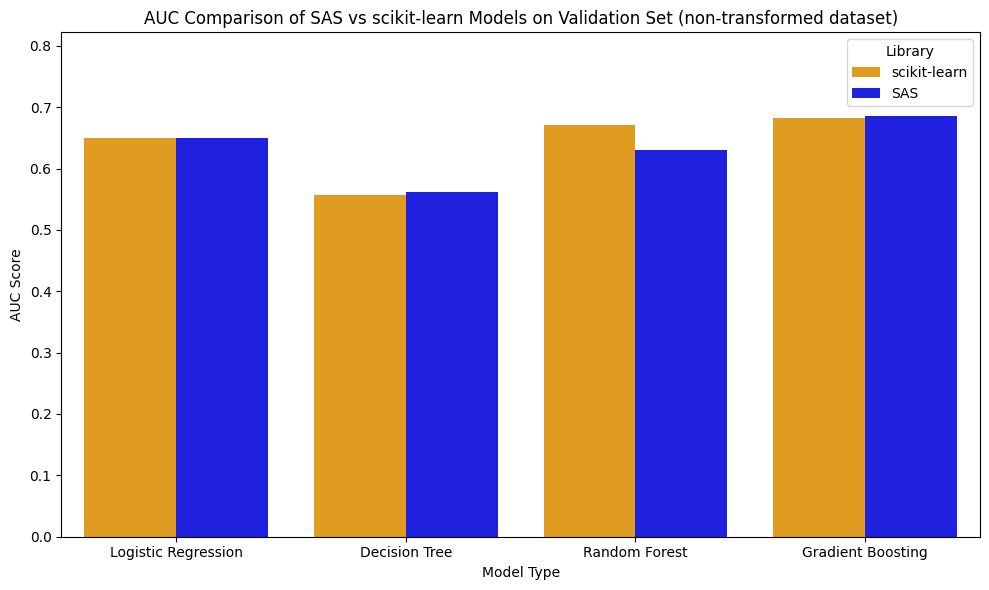

In [12]:
# Plotting
plt.figure(figsize=(10, 6))
colors = {"SAS": "blue", "scikit-learn": "orange"}
ax = sns.barplot(
    data=metrics_df, 
    x="Model Type", 
    y="AUC_val", 
    hue="Library", 
    palette=colors
)
plt.title("AUC Comparison of SAS vs scikit-learn Models on Validation Set (non-transformed dataset)")
plt.ylabel("AUC Score")
plt.xlabel("Model Type")
plt.legend(title="Library")
ax.set_ylim(0, metrics_df["AUC_val"].max() * 1.2)
plt.tight_layout()
plt.show()

#### Hyperparameter tuning and Model Selection

Let's take a closer look at model selection by performing hyperparameter tuning using the `Optuna` library. Optuna is an open-source framework for automated hyperparameter optimization that efficiently searches for the best parameter configurations using techniques such as **Tree-structured Parzen Estimator (TPE)**. In this case, I use Optuna to tune and compare three different classifiers:
- Random Forest
- Decision Tree
- Gradient Boosting

For these models, both the `scikit-learn` and `sasviya` versions have been implemented. The goal is to identify the optimal hyperparameters combination based on cross-validated AUC scores.

In [13]:
preprocessor = ColumnTransformer(
    transformers=[
        ('binary', OrdinalEncoder(categories=[['No', 'Yes']]*len(cat_cols_with_two_values)), cat_cols_with_two_values),
        ('ohe', OneHotEncoder(dtype='int64', handle_unknown='ignore', sparse_output=False), cat_cols_with_more_values)
    ],
    remainder='passthrough',  # Keep the remaining columns as they are
    force_int_remainder_cols=False
)

objective = Objective(X_train, y_train, preprocessor)
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=5)

[I 2025-02-07 10:16:55,228] A new study created in memory with name: no-name-1d9891dc-e9c3-4c98-9400-4e1f3caefe6a
[I 2025-02-07 10:16:56,412] Trial 0 finished with value: 0.6057702939283273 and parameters: {'classifier': 'dtree', 'library': 'sasviya', 'resampling': True, 'sampling_strategy': 0.3286502090265754, 'dtree_max_depth': 11, 'dtree_min_samples_leaf': 20}. Best is trial 0 with value: 0.6057702939283273.
[I 2025-02-07 10:17:00,512] Trial 1 finished with value: 0.5453123438115578 and parameters: {'classifier': 'gb', 'library': 'sklearn', 'resampling': False, 'gb_n_estimators': 29, 'gb_max_depth': 8, 'gb_min_samples_leaf': 7, 'gb_n_bins': 44, 'gb_subsample': 0.5942121201733399, 'gb_learning_rate': 1.0}. Best is trial 0 with value: 0.6057702939283273.
[I 2025-02-07 10:17:01,711] Trial 2 finished with value: 0.5948914746815737 and parameters: {'classifier': 'dtree', 'library': 'sasviya', 'resampling': True, 'sampling_strategy': 0.267947633487901, 'dtree_max_depth': 11, 'dtree_min_sa

In [14]:
# Define a function to create and train a pipeline with the best parameters
def train_best_pipeline(X, y, best_params, preprocessor):
    classifiers = {
        "sasviya": {"rf": create_sas_rf,
                    "dtree": create_sas_dtree,
                    "gb": create_sas_gb},
        "sklearn": {"rf": create_sklearn_rf,
                    "dtree": create_sklearn_dtree,
                    "gb": create_sklearn_gb},
    }

    # Extract the best parameters
    classifier_name = best_params["classifier"]
    library_name = best_params["library"]
    resampling = best_params["resampling"]

    # Create the classifier using the best parameters
    library_classifiers = classifiers[library_name]
    if classifier_name in library_classifiers:
        classifier_obj = library_classifiers[classifier_name](optuna.trial.FixedTrial(best_params))
    else:
        raise ValueError(f"Unsupported classifier: {classifier_name}")

    # Create the pipeline steps
    pipeline_steps = []
    pipeline_steps.append(('imputer', MissingValueImputer()))
    pipeline_steps.append(('cat_filter', CategoricalLevelFilter()))

    if library_name == "sklearn":
        pipeline_steps.append(('preprocessor', preprocessor))

    pipeline_steps.append(('model', classifier_obj))
    
    pipeline = Pipeline(pipeline_steps)

    if resampling:
        sampling_strategy = best_params["sampling_strategy"]
        rus = RandomUnderSampler(random_state=12345, sampling_strategy=sampling_strategy)
        X, y = rus.fit_resample(X, y)
    
    # Train the pipeline on the entire training set
    if library_name == "sasviya":
        cat_cols = X.select_dtypes(exclude='number').columns
        pipeline.fit(X, y, model__nominals=cat_cols)
    elif library_name == "sklearn":
        pipeline.fit(X, y)

    return pipeline

In [15]:
print("Set of best parameters:")
print(study.best_params)

Set of best parameters:
{'classifier': 'rf', 'library': 'sklearn', 'resampling': True, 'sampling_strategy': 0.4918112849700086, 'rf_n_estimators': 98, 'rf_max_depth': 12, 'rf_min_samples_leaf': 6, 'rf_max_samples': 0.4178428046175977, 'rf_n_bins': 30, 'rf_class_weight': None}


In [16]:
best_parameters = study.best_params
best_pipeline = train_best_pipeline(X_train, y_train, best_parameters, preprocessor)

In [17]:
# AUC score on test set
cat_levels = best_pipeline.named_steps['cat_filter'].levels
valid_rows_mask_train = X_train[list(cat_levels.keys())].apply(lambda col: col.isin(cat_levels[col.name])).all(axis=1)
valid_rows_mask_test = X_test[list(cat_levels.keys())].apply(lambda col: col.isin(cat_levels[col.name])).all(axis=1)
y_train = y_train[valid_rows_mask_train]
y_test = y_test[valid_rows_mask_test]

# Compute AUC scores
auc_train, auc_test = compute_auc(best_pipeline, X_train, y_train, X_test, y_test)
print(f"- AUC score on the train set: {auc_train:.2f}")
print(f"- AUC score on the test set: {auc_test:.2f}")

- AUC score on the train set: 0.85
- AUC score on the test set: 0.67


### Model Building for transformed dataset

In [18]:
merged_df = pd.read_csv(f"{repo_path}/data/merged_data_tfm.csv")
X_train, X_test, y_train, y_test, cat_cols, cat_cols_with_two_values, cat_cols_with_more_values, numeric_cols = split_data_and_generate_column_lists(merged_df, target)

- Number of rows with churn='No': 13052 (90.34 %)
- Number of rows with churn='Yes': 1395 (9.66 %)


In [19]:
sas_lr = SASLogisticRegression()
sklearn_lr = SKLogisticRegression(solver='liblinear')
sas_dtree = SASDecisionTreeClassifier()
sklearn_dtree = SKDecisionTreeClassifier()
sas_rf = SASForestClassifier()
sklearn_rf = SKRandomForestClassifier()
sas_gb = SASGradientBoostingClassifier()
sklearn_gb = SKGradientBoostingClassifier()

preprocessor = ColumnTransformer(
    transformers=[
        ('binary', OrdinalEncoder(categories=[['No', 'Yes']]*len(cat_cols_with_two_values)), cat_cols_with_two_values),
        ('ohe', OneHotEncoder(dtype='int64', handle_unknown='ignore', sparse_output=False), cat_cols_with_more_values)
    ],
    remainder='passthrough',  # Keep the remaining columns as they are
    force_int_remainder_cols=False
)

sklearn_lr_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', sklearn_lr)
])

dtree_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', sklearn_dtree)
])

rf_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', sklearn_rf)
])

gb_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', sklearn_gb)
])

In [20]:
sklearn_lr_model_metrics = train_and_evaluate_model(X_train, y_train, sklearn_lr_pipeline, 'Logistic Regression', 'scikit-learn', k=k, resampling=False, numeric_cols=numeric_cols)
sas_lr_model_metrics = train_and_evaluate_model(X_train, y_train, sas_lr, 'Logistic Regression', 'SAS', k=k, resampling=False, numeric_cols=numeric_cols, nominals=cat_cols)
sklearn_dtree_metrics = train_and_evaluate_model(X_train, y_train, dtree_pipeline, 'Decision Tree', 'scikit-learn', k=k, resampling=False)
sas_dtree_metrics = train_and_evaluate_model(X_train, y_train, sas_dtree, 'Decision Tree', 'SAS', k=k, resampling=False, nominals=cat_cols)
sklearn_rf_metrics = train_and_evaluate_model(X_train, y_train, rf_pipeline, 'Random Forest', 'scikit-learn', k=k, resampling=False)
sas_rf_metrics = train_and_evaluate_model(X_train, y_train, sas_rf, 'Random Forest', 'SAS', k=k, resampling=False, nominals=cat_cols)
sklearn_gb_metrics = train_and_evaluate_model(X_train, y_train, gb_pipeline, 'Gradient Boosting', 'scikit-learn', k=k, resampling=False)
sas_gb_metrics = train_and_evaluate_model(X_train, y_train, sas_gb, 'Gradient Boosting', 'SAS', k=k, resampling=False, nominals=cat_cols)

tfm_metrics_df = sklearn_lr_model_metrics
tfm_metrics_df = pd.concat([tfm_metrics_df, sas_lr_model_metrics], ignore_index=True)
tfm_metrics_df = pd.concat([tfm_metrics_df, sklearn_dtree_metrics], ignore_index=True)
tfm_metrics_df = pd.concat([tfm_metrics_df, sas_dtree_metrics], ignore_index=True)
tfm_metrics_df = pd.concat([tfm_metrics_df, sklearn_rf_metrics], ignore_index=True)
tfm_metrics_df = pd.concat([tfm_metrics_df, sas_rf_metrics], ignore_index=True)
tfm_metrics_df = pd.concat([tfm_metrics_df, sklearn_gb_metrics], ignore_index=True)
tfm_metrics_df = pd.concat([tfm_metrics_df, sas_gb_metrics], ignore_index=True)
tfm_metrics_df

,Model Type,Library,AUC_train,AUC_val,AUC_train_std,AUC_val_std
0,Logistic Regression,scikit-learn,0.667,0.644,0.007,0.008
1,Logistic Regression,SAS,0.668,0.645,0.007,0.008
2,Decision Tree,scikit-learn,1.000,0.555,0.000,0.010
3,Decision Tree,SAS,0.648,0.571,0.010,0.016
4,Random Forest,scikit-learn,1.000,0.660,0.000,0.004
5,Random Forest,SAS,0.835,0.632,0.009,0.010
6,Gradient Boosting,scikit-learn,0.818,0.669,0.004,0.009
7,Gradient Boosting,SAS,0.894,0.669,0.001,0.004


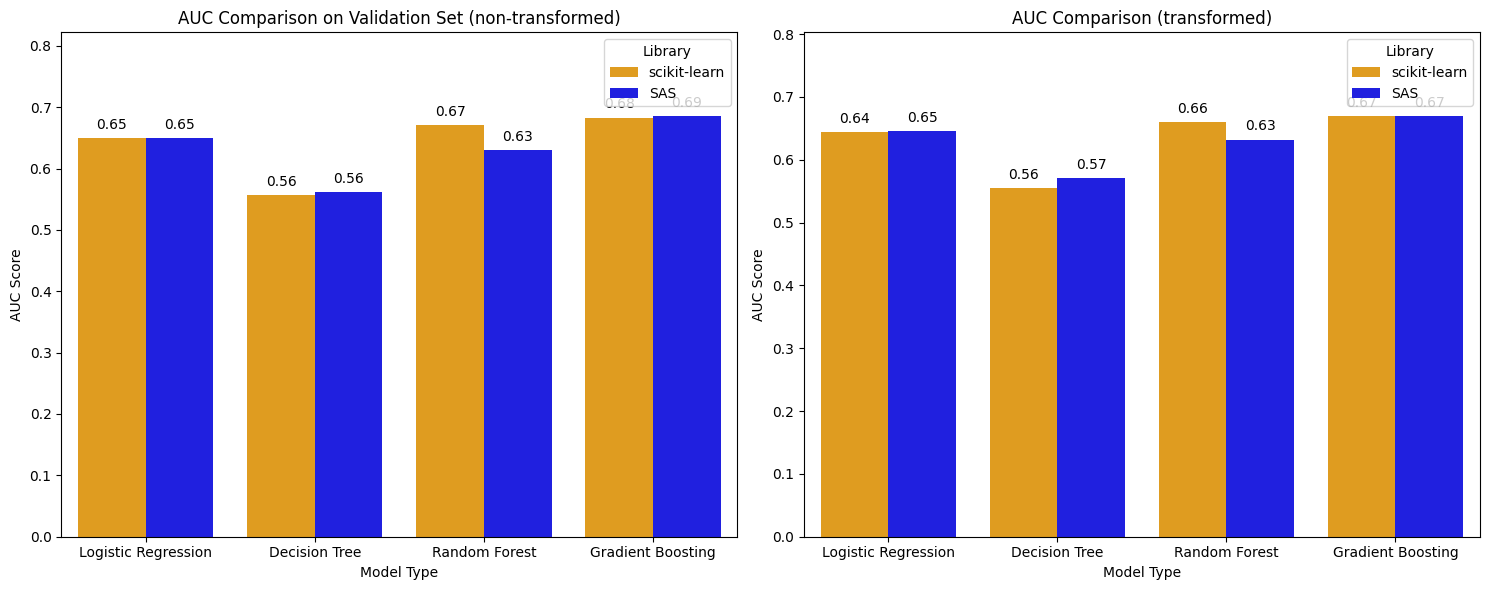

In [21]:
# Define color palette
colors = {"SAS": "blue", "scikit-learn": "orange"}

# Function to add labels to bars
def add_labels(ax):
    for p in ax.patches:
        ax.text(p.get_x() + p.get_width() / 2, p.get_height() + 0.01, 
                f"{p.get_height():.2f}", ha='center', va='bottom', fontsize=10)

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Plot for non-transformed dataset
sns.barplot(data=metrics_df, x="Model Type", y="AUC_val", hue="Library", palette=colors, ax=axes[0])
axes[0].set(title="AUC Comparison on Validation Set (non-transformed)", ylabel="AUC Score", xlabel="Model Type")
axes[0].set_ylim(0, metrics_df["AUC_val"].max() * 1.2)
add_labels(axes[0])

# Plot for transformed dataset
sns.barplot(data=tfm_metrics_df, x="Model Type", y="AUC_val", hue="Library", palette=colors, ax=axes[1])
axes[1].set(title="AUC Comparison (transformed)", ylabel="AUC Score", xlabel="Model Type")
axes[1].set_ylim(0, tfm_metrics_df["AUC_val"].max() * 1.2)
add_labels(axes[1])

# Adjust layout and display
plt.tight_layout()
plt.show()

In this case as well, we observe overfitting in the tree models. Furthermore, there doesn't appear to be a significant improvement in the AUC score compared to the non-transformed dataset. Nonetheless, we will proceed with hyperparameter tuning and ultimately select the best model, either from the non-transformed or transformed dataset, based on their test set performance.

In [22]:
# Define hyperparameter search space for each model
# def create_lr(trial):
#     lr_class_weight = trial.suggest_categorical("lr_class_weight", [None, "balanced"])
#     lr_c = trial.suggest_float("lr_c", 1e-2, 1e2, log=True)
#     return LogisticRegression(C=lr_c,
#                               class_weight=lr_class_weight)

# def create_svc(trial):
#     svc_class_weight = trial.suggest_categorical("svc_class_weight", [None, "balanced"])
#     svc_c = trial.suggest_float("svc_c", 1e-2, 1e2, log=True)
#     svc_kernel = trial.suggest_categorical("svc_kernel", ["poly", "rbf", "sigmoid", "linear"])
#     return SVC(C=svc_c,
#                kernel=svc_kernel,
#                class_weight=svc_class_weight)

# def get_best_pipeline(parameters):
    
#     if parameters["classifier"] == "dtree":
#         model = LogisticRegression(C=parameters["lr_c"],
#                                    class_weight=parameters["lr_class_weight"])
#     elif parameters["classifier"] == "rf":
#         if parameters["nb_classifier_type"] == "multinomial":
#             model = MultinomialNB(alpha=parameters["nb_alpha"])
#         else:
#             model = ComplementNB(alpha=parameters["nb_alpha"])
#     elif parameters["classifier"] == "gb":
#         model = SVC(
#             C=parameters["svc_c"],
#             kernel=parameters["svc_kernel"],
#             class_weight=parameters["svc_class_weight"]
#         )
        
#     return Pipeline([
#         ('tfidf', tfidf_vectorizer),
#         ('model', model)
#     ])

In [23]:
import optuna

preprocessor = ColumnTransformer(
    transformers=[
        ('binary', OrdinalEncoder(categories=[['No', 'Yes']]*len(cat_cols_with_two_values)), cat_cols_with_two_values),
        ('ohe', OneHotEncoder(dtype='int64', handle_unknown='ignore', sparse_output=False), cat_cols_with_more_values)
    ],
    remainder='passthrough',  # Keep the remaining columns as they are
    force_int_remainder_cols=False
)

objective = Objective(X_train, y_train, preprocessor)
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=5)

[I 2025-02-07 10:26:30,776] A new study created in memory with name: no-name-1f125e63-0270-4e49-8130-585155a919a9
[I 2025-02-07 10:27:42,531] Trial 0 finished with value: 0.5590988657352004 and parameters: {'classifier': 'rf', 'library': 'sasviya', 'resampling': False, 'rf_n_estimators': 44, 'rf_max_depth': 11, 'rf_min_samples_leaf': 21, 'rf_bootstrap': 0.6539940051432447, 'rf_n_bins': 31}. Best is trial 0 with value: 0.5590988657352004.
[I 2025-02-07 10:28:57,610] Trial 1 finished with value: 0.6232904110510965 and parameters: {'classifier': 'gb', 'library': 'sasviya', 'resampling': False, 'gb_n_estimators': 45, 'gb_max_depth': 10, 'gb_min_samples_leaf': 13, 'gb_n_bins': 39, 'gb_subsample': 0.5771593731634885, 'gb_learning_rate': 1.0}. Best is trial 1 with value: 0.6232904110510965.
[I 2025-02-07 10:29:42,082] Trial 2 finished with value: 0.6565279405254173 and parameters: {'classifier': 'gb', 'library': 'sklearn', 'resampling': True, 'sampling_strategy': 0.2925561528985601, 'gb_n_est

In [24]:
print("Set of best parameters:")
print(study.best_params)

Set of best parameters:
{'classifier': 'gb', 'library': 'sklearn', 'resampling': True, 'sampling_strategy': 0.2925561528985601, 'gb_n_estimators': 69, 'gb_max_depth': 5, 'gb_min_samples_leaf': 26, 'gb_n_bins': 30, 'gb_subsample': 0.5263915586720386, 'gb_learning_rate': 0.01}


In [25]:
best_parameters = study.best_params
best_pipeline = train_best_pipeline(X_train, y_train, best_parameters, preprocessor)

In [26]:
# AUC score on test set
cat_levels = best_pipeline.named_steps['cat_filter'].levels
valid_rows_mask = X_test[list(cat_levels.keys())].apply(lambda col: col.isin(cat_levels[col.name])).all(axis=1)
y_test = y_test[valid_rows_mask]

# Compute AUC scores
auc_train, auc_test = compute_auc(best_pipeline, X_train, y_train, X_test, y_test)
print(f"- AUC score on the test set: {auc_test:.2f}")

- AUC score on the test set: 0.71


### Cutoff optimization

The SAS Gradient Boosting model is the one performing better on test data. Therefore, this is the model we'll choose for identifying churners among our customer base to take action and try to keep them. 

Let's assume that to prevent a client from churning, PowerCo issues a 10% discount on their electricity price. We also assume that the efficiency of this discount is 80%, i.e. 80% of the targeted at-risk customers are persuaded to stay after receiving the discount.

Even though PowerCo doesn't want either to lose a client and is ready to give it a discount, they don't want to hand out free discounts and offer it also to customers who would stay anyway. Keeping that in mind, let's now identify the churn probability threshold that enables us to optimize the overall profit for PowerCo. The estimation of the optimal probability cutoff is performed using the test, in order to simulate how the model would behave on unseen data.

To this aim, we can compute for different probability thresholds the profit function as:
$$
\text{Profit}(p)=\text{Gains}-\text{Loss}+\text{Prevented Loss}-\text{Discount Loss}
$$
where:
- **Gains** represents the total potential profit if no customers churn, therefore this value assumes a perfect scenario where all customers are retained. The profit represents the average annual profit and has been calculated using the `margin_net_pow_ele` variable, which denotes the net margin on power subscriptions. This margin is assumed to refer to the average monthly margin and was therefore multiplied by 12 to derive the annual value.
- **Loss** represents the total profit lost due to customers who churned. This value accounts for the revenue lost because these customers are no longer contributing profit.

For each scenario, the retention campaign targets all customers with a predicted churn likelihood exceeding the probability threshold, $p$. 
- **Prevented Loss** is the profit gained from customers who were predicted to churn and actually churned, but would've been retained due to the campaign. This is scaled by the discount efficiency.
$$
\text{Prevented Loss}=\text{Sum of profits from targeted churners}\times\text{Discount Efficiency}
$$
- **Discount Loss** represents the total cost of offering discounts to targeted high-risk customers, broken down as follows:
    - **For non-churners**: The profit from customers who were predicted to churn but did not actually churn, multiplied by the discount rate, as they would've been targeted by the campaign.
        $$
        \text{Discount Loss (Non-Churners)} = \text{Sum of profits from targeted non-churners}\times\text{Discount Rate}
        $$
    - **For Churners**: The prevented loss scaled by the discount rate.
        $$
        \text{Discount Loss (Churners)} = \text{Prevented Loss}\times\text{Discount Rate}
        $$
    The total discount loss is the sum of these two components:
    $$
    \text{Discount Loss} = \text{Discount Loss (Non-Churners)} + \text{Discount Loss (Churners)}
    $$
    **Note**: In our example, we might assume that the discount is operated on the net margin (`margin_net_pow_ele` variable, which is only a component of the total tariff), to make computations easier, but it should be actually properly defined what a 10% tariff discount means.

Then, choose the threshold $p^*$ leading to the highest profit, given by $Profit(p^*)$.
We can compare this situation with what would’ve happened if we didn’t do anything:
$$
\text{Profit}=\text{Gains}-\text{Loss}
$$
to compute the financial impact of our model (percent improvement in profit). This value represents the baseline scenario in which no effort is made to prevent churn, and the business simply absorbs the loss from churned customers.

A <u>lower</u> probability threshold expands the retention campaign to more customers, leading to a higher `Discount Loss`.<br>Conversely, a <u>higher</u> probability threshold excludes some potential churners from the discount offer, increasing the risk of losing them and, therefore, decreasing the `Prevented Loss` term.

Regarding the annual profit, we will use the `margin_net_pow_ele_log` variable. However, we need to retrieve the original values, which can be obtained by applying the inverse transformation of $log(1+x)$, i.e. $x=exp(y)-1$.

Optimal threshold: 0.2563
At this threshold, apply a 10.0% discount to identified high-risk customers.
Estimated financial impact: 26952.77 € (3.63% increase in profit compared to no intervention).
658 out of 2890 customers (22.77%) would receive the discount.


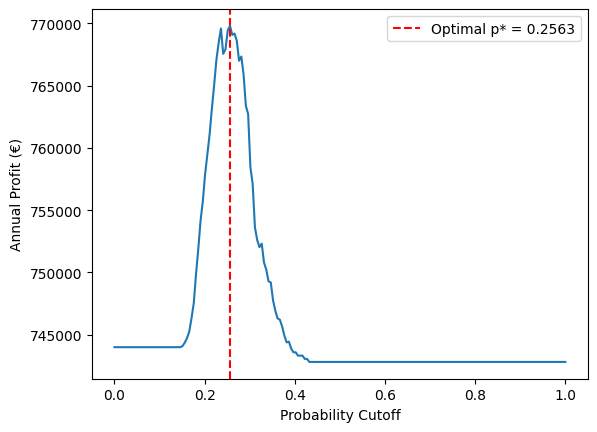

In [27]:
margins = np.expm1(X_test.iloc[:,list(X_test.columns).index('margin_net_pow_ele_log')])

# y_pred_proba = best_pipeline.predict_proba(X_test).iloc[:,1]
y_pred_proba = best_pipeline.predict_proba(X_test)[:,1]
test_model(y_test, y_pred_proba, margins, discount_rate=0.1, discount_efficiency=0.8)

### Next Steps

- Both when predicting a customer's churn likelihood and when determining the discount to offer a potential churner, considering **competitor tariffs** could be valuable. 
This can be achieved by introducing a new variable, such as `competitor_avg_tariff_lastmonth`, which represents the average tariff for the last month of the historical data period. This value can be calculated using data from sources like CHECK24, taking into account the *postal code* and the *number of kilowatt-hours consumed* (based on actual or estimated readings). These two inputs are essential for CHECK24's tariff comparisons, helping users identify the most competitive offers. The discount is an hyperparameter of the model, in a sense, that can be tuned based on how much increase in profit you want to achieve and/or on the average current competitor price for the customer we are considering. For example, based on postal code and number of kWh consumed, the average competitor price can change, and then considering the percent difference between PowerCo tariff and average tariff can help us choose the discount needed in order for it to be effective.
- An additional step that could enhance the analysis is performing **customer segmentation** prior to training the churn model. By using clustering techniques, we could train separate churn models for each customer segment, allowing us to better understand the distinct patterns within different types of customers. This approach was not implemented in this project due to the limited data available for training, but it could provide valuable insights and improve the model's performance in the future.

### Conclusions

To wrap up, in this project we performed churn prediction for an energy company using data from the `'client_data_raw.csv'` and `'price_data_raw.csv'` files. The workflow was divided into three main parts:

- **Data Quality and Preprocessing** (`'Churn Prediction - Part 1'`):
    - We began by inspecting variable types and performing data quality checks.
    - Inconsistent rows were identified, removed, and saved to CSV files for further investigation with the data provider.
- **Feature Engineering and Data Transformation** (`'Churn Prediction - Part 2'`):
    - We summarized the price values for each customer ID and merged the datasets.
    - Several feature engineering and data transformation steps were implemented to prepare the data for modeling.
- **Model Building and Evaluation** (`'Churn Prediction - Part 3'`):
    - We trained and compared multiple machine learning models using both scikit-learn and SAS via the **Python API in SAS Viya Workbench**.
    - Model performance was evaluated using cross-validated AUC scores.
    - After selecting the best-performing model, we retrained it on the entire training set.
    - We determined the optimal probability cutoff that maximized company profit, simulating a retention campaign in which discounts were offered to customers predicted as likely churners. The cutoff optimization was customized based on assumed retention efficiency and discount rates.

By following this structured approach, we provided a comprehensive framework for churn prediction, enabling the energy company to enhance its retention strategies, minimize customer loss, and maximize its profit effectively.